In [ ]:
Wichtige Links:
Unconditional latent diffusion pipeline: https://huggingface.co/docs/diffusers/main/en/api/pipelines/latent_diffusion_uncond 
Github Link: https://github.com/huggingface/diffusers/blob/main/src/diffusers/pipelines/deprecated/latent_diffusion_uncond/pipeline_latent_diffusion_uncond.py

VQ-VAE: https://huggingface.co/docs/diffusers/main/en/api/models/vq#diffusers.VQModel
Nicht sicher: Github VQModel: https://github.com/huggingface/diffusers/blob/main/src/diffusers/models/autoencoders/vae.py 





In [9]:
#create config
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    image_size = 256  # TODO: the generated image resolution
    channels = 1
    train_batch_size = 4 # 16
    eval_batch_size = 16  # how many images to sample during evaluation
    num_epochs = 600
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    evaluate_epochs = 30
    save_model_epochs = 300
    mixed_precision = "fp16"  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = "lesion-filling-256"  # the model name locally and on the HF Hub
    dataset_path = "./dataset/imgs"
    segm_path = "./dataset/segm"
    num_gpu=2
    #uniform_dataset_path = "./uniform_dataset"

    push_to_hub = False  # whether to upload the saved model to the HF Hub
    #hub_model_id = "<your-username>/<my-awesome-model>"  # the name of the repository to create on the HF Hub
    #hub_private_repo = False
    #overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0
config = TrainingConfig()

In [10]:
from diffusers import UNet2DConditionModel, VQModel, LDMPipeline

/*
vq_model = VQModel(
    sample_size=config.image_size,  # the target image resolution
    in_channels=config.channels,  # the number of input channels, 3 for RGB images
    out_channels=config.channels,  # the number of output channels
)
*/



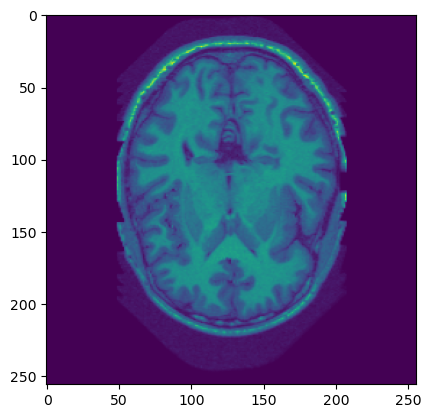

In [16]:
#zuerst dataset laden
plt.imshow((datasetTrain[1]["gt_image"].squeeze()+1)/2)

In [20]:
latent=vq_model.encode(datasetTrain[1]["gt_image"].unsqueeze(0))

In [28]:
#plt.imshow((latent.latents.detach().numpy().squeeze()+1)/2)

In [34]:
img=vq_model.decode(latent.latents)

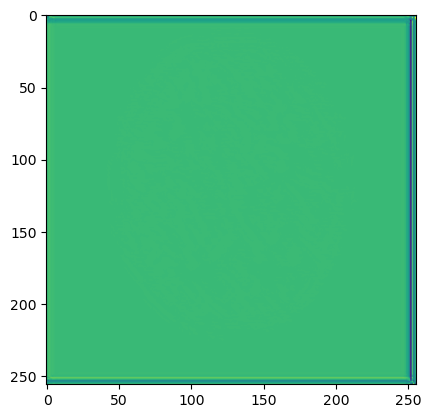

In [39]:
import matplotlib.pyplot as plt
plt.imshow(img.sample.detach().numpy().squeeze())

In [11]:
#setup huggingface accelerate
import accelerate
accelerate.commands.config.default.write_basic_config(config.mixed_precision)

#setup tensorboard
import torch
from torch.utils.tensorboard import SummaryWriter
tb_summary = SummaryWriter(config.output_dir, purge_step=0)

Configuration already exists at /home/jovyan/.cache/huggingface/accelerate/default_config.yaml, will not override. Run `accelerate config` manually or pass a different `save_location`.


2024-03-12 13:39:48.605325: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-12 13:39:49.161067: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-12 13:39:49.161215: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-12 13:39:49.161828: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-12 13:39:49.488179: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-12 13:39:49.491904: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [12]:
#log at tensorboard
tb_summary.add_scalar("image_size", config.image_size, 0)
tb_summary.add_scalar("train_batch_size", config.train_batch_size, 0)
tb_summary.add_scalar("eval_batch_size", config.eval_batch_size, 0)
tb_summary.add_scalar("num_epochs", config.num_epochs, 0)
tb_summary.add_scalar("learning_rate", config.learning_rate, 0)
tb_summary.add_scalar("lr_warmup_steps", config.lr_warmup_steps, 0)
tb_summary.add_scalar("evaluate_epochs", config.evaluate_epochs, 0)
tb_summary.add_text("mixed_precision", config.mixed_precision, 0) 

In [13]:
# create dataset
from torch.utils.data import Dataset
from torch.nn import functional as F
from pathlib import Path
import nibabel as nib
import numpy as np
from math import floor, ceil

class DatasetMRI(Dataset):
    """
    Dataset for Training purposes. 
    Adapted implementation of BraTS 2023 Inpainting Challenge (https://github.com/BraTS-inpainting/2023_challenge).
    
    Contains ground truth t1n images (gt) 
    Args:
        root_dir_img: Path to img files
        root_dir_segm: Path to segmentation maps
        pad_shape: Shape the images will be transformed to

    Raises:
        UserWarning: When your input images are not (256, 256, 160)

    Returns: 
        __getitem__: Returns a dictoinary containing:
            "gt_image": Padded and cropped version of t1n 2D slice
            "t1n_path": Path to the unpadded t1n file for this sample
            "max_v": Maximal value of t1 image (used for normalization) 
    """

    def __init__(self, root_dir_img: Path, root_dir_segm: Path, pad_shape=(256,256,256)):
        #Initialize variables
        self.root_dir_img = root_dir_img
        self.root_dir_segm = root_dir_segm
        self.pad_shape = pad_shape 
        self.list_paths_t1n = list(root_dir_img.rglob("*.nii.gz"))
        self.list_paths_segm = list(root_dir_segm.rglob("*.nii.gz"))
        #define offsets between first and last segmented slices and the slices to be used for training
        bottom_offset=60 
        top_offset=20

        #go through all 3D imgs
        idx=0
        self.idx_to_2D_slice = dict()
        for j, path in enumerate(self.list_paths_segm):
            t1n_segm = nib.load(path)
            t1n_3d = t1n_segm.get_fdata()

            #get first slice with segmented content and add offset
            i=0
            while(not t1n_3d[:,i,:].any()):
                i+=1
            bottom=i+bottom_offset

            #get last slice with segmented content and add offset
            i=t1n_3d.shape[1]-1
            while(not t1n_3d[:,i,:].any()):
                i-=1
            top=i-top_offset

            #Add all slices between desired top and bottom slice to dataset
            for i in np.arange(top-bottom):
                self.idx_to_2D_slice[idx]=(self.list_paths_t1n[j],bottom+i)
                idx+=1 

    def __len__(self): 
        return len(self.idx_to_2D_slice.keys()) 

    def preprocess(self, t1n: np.ndarray):
        """
        Transforms the images to a more unified format.
        Normalizes to -1,1. Pad and crop to bounding box.
        
        Args:
            t1n (np.ndarray): t1n from t1n file (ground truth).

        Raises:
            UserWarning: When your input images are not (256, 256, 160)

        Returns:
            t1n: The padded and cropped version of t1n.
            t1n_max_v: Maximal value of t1n image (used for normalization).
        """

        #Size assertions
        reference_shape = (256,256,160)
        if t1n.shape != reference_shape:
            raise UserWarning(f"Your t1n shape is not {reference_shape}, it is {t1n.shape}")

        #Normalize the image to [0,1]
        t1n[t1n<0] = 0 #Values below 0 are considered to be noise #TODO: Check validity
        t1n_max_v = np.max(t1n)
        t1n /= t1n_max_v

        #pad to bounding box
        size = self.pad_shape # shape of bounding box is (size,size,size) #TODO: Find solution for 2D
        t1n = torch.Tensor(t1n)
        d, w, h = t1n.shape[-3], t1n.shape[-2], t1n.shape[-1]
        d_max, w_max, h_max = size
        d_pad = max((d_max - d) / 2, 0)
        w_pad = max((w_max - w) / 2, 0)
        h_pad = max((h_max - h) / 2, 0)
        padding = (
            int(floor(h_pad)),
            int(ceil(h_pad)),
            int(floor(w_pad)),
            int(ceil(w_pad)),
            int(floor(d_pad)),
            int(ceil(d_pad)),
        )
        t1n = F.pad(t1n, padding, value=0, mode="constant") 

        #map images from [0,1] to [-1,1]
        t1n = (t1n*2) - 1

        return t1n, t1n_max_v

    def __getitem__(self, idx):
        t1n_path = self.idx_to_2D_slice[idx][0]
        slice_idx = self.idx_to_2D_slice[idx][1]
        t1n_img = nib.load(t1n_path)
        t1n = t1n_img.get_fdata()
        
        # preprocess data
        t1n, t1n_max_v = self.preprocess(t1n) # around 0.2s on local machine
        
        # get 2D slice from 3D
        t1n_slice = t1n[:,slice_idx,:] 
        
        # Output data
        sample_dict = {
            "gt_image": t1n_slice.unsqueeze(0),
            "t1n_path": str(t1n_path),  # path to the 3D t1n file for this sample.
            "max_v": t1n_max_v,  # maximal t1n_voided value used for normalization 
        }
        return sample_dict 

In [14]:
#create dataset
datasetTrain = DatasetMRI(Path(config.dataset_path), Path(config.segm_path), pad_shape=(256, 256, 256)) # TODO: check shape

print(f"Dataset size: {len(datasetTrain)}")
print(f"\tImage shape: {datasetTrain[0]['gt_image'].shape}")
print(f"Training Data: {list(datasetTrain[0].keys())}") 

Dataset size: 1080
	Image shape: torch.Size([1, 256, 256])
Training Data: ['gt_image', 't1n_path', 'max_v']


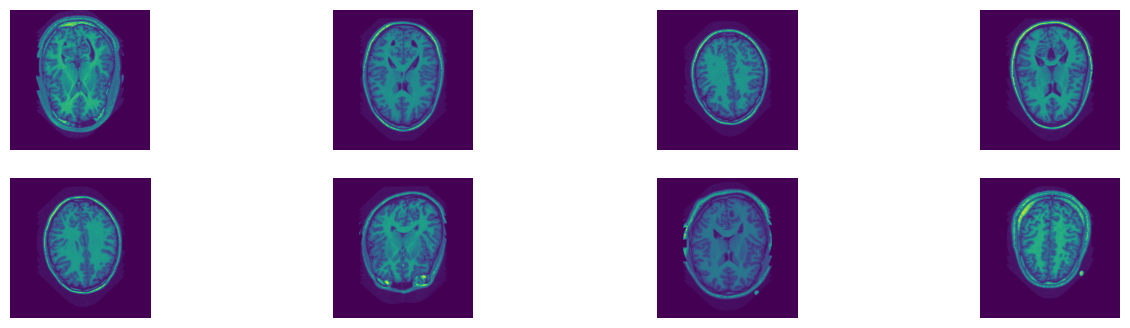

In [15]:
# plot random image
import matplotlib.pyplot as plt

# Get 8 random sample
random_indices = np.random.randint(0, len(datasetTrain) - 1, size=(8)) 

# Plot: t1n
fig, axis = plt.subplots(2,4,figsize=(16,4))
for i, idx in enumerate(random_indices):
    axis[i//4,i%4].imshow((datasetTrain[idx]["gt_image"].squeeze()+1)/2)
    axis[i//4,i%4].set_axis_off()
fig.show()

In [11]:
from torch.utils.data import DataLoader

# create dataloader function, which is executed inside the training loop (necessary because of huggingface accelerate)
def get_dataloader():
    return DataLoader(datasetTrain, batch_size=config.train_batch_size, shuffle=True, num_workers=4)

In [12]:
#create model
from diffusers import UNet2DModel

model = UNet2DModel(
    sample_size=config.image_size,  # the target image resolution
    in_channels=config.channels,  # the number of input channels, 3 for RGB images
    out_channels=config.channels,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(128, 128, 256, 256, 512, 512),  # the number of output channels for each UNet block
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)

tb_summary.add_text("model", "UNet2DModel", 0) 

/opt/conda/lib/python3.11/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [13]:
#check if image size matches
sample_image = datasetTrain[0]['gt_image'].unsqueeze(0)
print("Input shape:", sample_image.shape)

print("Output shape:", model(sample_image, timestep=0).sample.shape)

Input shape: torch.Size([1, 1, 256, 256])
Output shape: torch.Size([1, 1, 256, 256])


In [14]:
#setup noise scheduler
import torch
from PIL import Image
from diffusers import DDIMScheduler

noise_scheduler = DDIMScheduler(num_train_timesteps=1000)
noise = torch.randn(sample_image.shape)
timesteps = torch.LongTensor([50])
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)

tb_summary.add_text("noise_scheduler", "DDIMScheduler(num_train_timesteps=1000)", 0) 

#Image.fromarray(((noisy_image.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0])




In [15]:
# setup lr scheduler
from diffusers.optimization import get_cosine_schedule_with_warmup
import math

optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(math.ceil(len(datasetTrain)/config.train_batch_size) * config.num_epochs), # num_iterations per epoch * num_epochs
)

tb_summary.add_text("lr_scheduler", "cosine_schedule_with_warmup", 0) 

In [16]:
#setup evaluation
from diffusers import DDIMPipeline
from diffusers.utils import make_image_grid
import os

def evaluate(config, epoch, pipeline):
    # Sample some images from random noise (this is the backward diffusion process).
    # The default pipeline output type is `List[PIL.Image]` 
    images = pipeline(
        batch_size=config.eval_batch_size,
        generator=torch.manual_seed_all(config.seed),
    ).images 
    # Make a grid out of the images
    image_grid = make_image_grid(images, rows=4, cols=4)

    # Save the images
    test_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")
    print("image saved")

#TODO: As soon as I evaluate metrics I need to adjust the evaluate function to accelerate

In [17]:
#from accelerate import Accelerator
from accelerate import Accelerator
from huggingface_hub import create_repo, upload_folder
from tqdm.auto import tqdm
from pathlib import Path
import os 
import torch.nn as nn 
import torch.nn.functional as F
import sys
import time

def train_loop(config, model, noise_scheduler, optimizer, lr_scheduler):
    # setup training environment
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps, 
        log_with="tensorboard",
        project_dir=os.path.join(config.output_dir, "tensorboard"),
    )

    if accelerator.is_main_process:
        if config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True) 
        accelerator.init_trackers("train_example")

    train_dataloader = get_dataloader()

    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )
    
    os.makedirs(config.output_dir, exist_ok=True)  

    global_step = 0
    
    # Train model
    model.train()
    for epoch in range(config.num_epochs): 
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process) 
        progress_bar.set_description(f"Epoch {epoch}") 
        
        for step, batch in enumerate(train_dataloader): 
            
            clean_images = batch["gt_image"]
            clean_images = clean_images 
            
            # Sample noise to add to the images
            noise = torch.randn(clean_images.shape, device=clean_images.device)
            bs = clean_images.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, (bs,), device=clean_images.device,
                dtype=torch.int64
            )

            # Add noise to the clean images according to the noise magnitude at each timestep (forward diffusion process)
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            with accelerator.accumulate(model):
                # Predict the noise residual
                noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)
                accelerator.clip_grad_norm_(model.parameters(), 1.0)
    
                #log gradient norm 
                parameters = [p for p in model.parameters() if p.grad is not None and p.requires_grad]
                if len(parameters) == 0:
                    total_norm = 0.0
                else: 
                    total_norm = torch.norm(torch.stack([torch.norm(p.grad.detach()).cpu() for p in parameters]), 2.0).item()

                #do learning step
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            progress_bar.update(1)

            # save logs
            if accelerator.is_main_process:
                logs = {"loss": loss.cpu().detach().item(), "lr": lr_scheduler.get_last_lr()[0], "total_norm": total_norm, "step": global_step}
                tb_summary.add_scalar("loss", logs["loss"], global_step)
                tb_summary.add_scalar("lr", logs["lr"], global_step) 
                tb_summary.add_scalar("total_norm", logs["total_norm"], global_step) 
            
                progress_bar.set_postfix(**logs)
                #accelerator.log(logs, step=global_step)
            global_step += 1 

        # After a certain number of epochs it samples some images with evaluate() and save the model
        if accelerator.is_main_process:
            model.eval()
            pipeline = DDIMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler) 
    
            if (epoch) % config.evaluate_epochs == 0 or epoch == config.num_epochs - 1:
                evaluate(config, epoch, pipeline)
    
            if (epoch) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1: 
                pipeline.save_pretrained(config.output_dir)

tb_summary.add_text("inference_pipeline", "DDIMPipeline", 0) 

In [19]:
from accelerate import notebook_launcher

# If run from a jupyter notebook then uncomment the two lines and remove last line
#args = (config, model, noise_scheduler, optimizer, lr_scheduler)
#notebook_launcher(train_loop, args, num_processes=config.num_gpu)    

train_loop(config, model, noise_scheduler, optimizer, lr_scheduler)

Launching training on 2 GPUs.


/opt/conda/lib/python3.11/site-packages/accelerate/state.py:306: UserWarning: OMP_NUM_THREADS/MKL_NUM_THREADS unset, we set it at 2 to improve oob performance.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/accelerate/state.py:306: UserWarning: OMP_NUM_THREADS/MKL_NUM_THREADS unset, we set it at 2 to improve oob performance.
  warnings.warn(
[W socket.cpp:464] [c10d] The server socket has failed to bind to [::]:29500 (errno: 98 - Address already in use).
[W socket.cpp:464] [c10d] The server socket has failed to bind to 0.0.0.0:29500 (errno: 98 - Address already in use).
[E socket.cpp:500] [c10d] The server socket has failed to listen on any local network address.


RuntimeError: An issue was found when launching the training: 

-- Process 0 terminated with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/site-packages/torch/multiprocessing/spawn.py", line 68, in _wrap
    fn(i, *args)
  File "/opt/conda/lib/python3.11/site-packages/accelerate/utils/launch.py", line 570, in __call__
    self.launcher(*args)
  File "/tmp/ipykernel_6284/383658007.py", line 14, in train_loop
    accelerator = Accelerator(
                  ^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/site-packages/accelerate/accelerator.py", line 378, in __init__
    self.state = AcceleratorState(
                 ^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/site-packages/accelerate/state.py", line 771, in __init__
    PartialState(cpu, **kwargs)
  File "/opt/conda/lib/python3.11/site-packages/accelerate/state.py", line 314, in __init__
    torch.distributed.init_process_group(self.backend, rank=rank, world_size=size, **kwargs)
  File "/opt/conda/lib/python3.11/site-packages/torch/distributed/c10d_logger.py", line 86, in wrapper
    func_return = func(*args, **kwargs)
                  ^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/site-packages/torch/distributed/distributed_c10d.py", line 1177, in init_process_group
    store, rank, world_size = next(rendezvous_iterator)
                              ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/site-packages/torch/distributed/rendezvous.py", line 246, in _env_rendezvous_handler
    store = _create_c10d_store(master_addr, master_port, rank, world_size, timeout, use_libuv)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/site-packages/torch/distributed/rendezvous.py", line 174, in _create_c10d_store
    return TCPStore(
           ^^^^^^^^^
torch.distributed.DistNetworkError: The server socket has failed to listen on any local network address. The server socket has failed to bind to [::]:29500 (errno: 98 - Address already in use). The server socket has failed to bind to 0.0.0.0:29500 (errno: 98 - Address already in use).


In [23]:
#create python script for ubelix
!jupyter nbconvert --to script "lesion_filling_unconditioned.ipynb"
filename="lesion_filling_unconditioned.py"

# delete this cell from python file
lines = []
with open(filename, 'r') as fp:
    lines = fp.readlines()
with open(filename, 'w') as fp:
    for number, line in enumerate(lines):
        if number < len(lines)-17: 
            fp.write(line)

[NbConvertApp] Converting notebook lesion_filling_unconditioned.ipynb to script
[NbConvertApp] Writing 17648 bytes to lesion_filling_unconditioned.py
